
#Etude comparative des Model Quantique QCNN et Classique CNN pour la classificaion d 'image
## 1. Présentation

Cette étude analyse les performances des **Quantum Convolutionnal Neural Networks**, une architecture hybride combinant l'informatique quantique et les réseaux de neurones classiques (CNN) pour la classification d'images (dataset MNIST).

## 2. Architecture du Modèle

Le système repose sur une structure en deux étapes :

* **Couche de prétraitement quantique :** Utilise 4 qubits pour transformer des patchs d'image de . Les données sont encodées via des rotations  et entrelacées par des portes .
* **Backend classique :** Un réseau dense standard (128 neurones, activation ReLU) qui effectue la classification finale à partir des caractéristiques extraites par la couche quantique.


### Observations  :

* **Avantage Quantique :** Une amélioration nette  sur la précision de validation.
* **Extraction de caractéristiques :** La capacité des circuits quantiques à utiliser la superposition et l'intrication permet de capturer des motifs plus complexes que les filtres de convolution standards.
* **Robustesse :** Le modèle quantique présente une meilleure généralisation et des frontières de décision plus nettes.

## 4. Limites et Enjeux

* **Coût computationnel :** Le traitement quantique impose une surcharge importante en termes de temps de calcul et de mémoire.
* **Scalabilité :** Nécessite une optimisation des circuits pour passer à des images de plus haute résolution (actuellement réduit à ).


In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor
import gc
import psutil
import multiprocessing
from multiprocessing import Pool

In [ ]:
def resize_classical_images(images):
    return tf.image.resize(images, (7, 7))

def visualize_preprocessing(original_images, quantum_processed_images, resized_images):
    n_samples = min(5, len(original_images))
    fig, axes = plt.subplots(3, n_samples, figsize=(15, 9))

    for i in range(n_samples):
        axes[0, i].imshow(original_images[i, ..., 0], cmap='gray', vmin=0, vmax=1)
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original (28x28)')

        axes[1, i].imshow(resized_images[i, ..., 0], cmap='gray', vmin=0, vmax=1)
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Resized (7x7)')

        quantum_img = quantum_processed_images[i]
        quantum_img = (quantum_img - tf.reduce_min(quantum_img)) / (tf.reduce_max(quantum_img) - tf.reduce_min(quantum_img))
        quantum_img_display = tf.reduce_mean(quantum_img, axis=-1)
        axes[2, i].imshow(quantum_img_display, cmap='gray', vmin=0, vmax=1)
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title('Quantum Processed')

    plt.tight_layout()
    plt.show()

    print("\nImage statistics:")
    print(f"Original shape: {original_images[0].shape}")
    print(f"Resized shape: {resized_images[0].shape}")
    print(f"Quantum processed shape: {quantum_processed_images[0].shape}")

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

    original_vals = tf.reshape(original_images[0], [-1]).numpy()
    resized_vals = tf.reshape(resized_images[0], [-1]).numpy()
    quantum_vals = tf.reshape(quantum_processed_images[0], [-1]).numpy()

    ax1.hist(original_vals, bins=50, color='gray')
    ax1.set_title('Original Distribution')
    ax1.set_xlabel('Pixel Value')
    ax1.set_ylabel('Frequency')

    ax2.hist(resized_vals, bins=50, color='gray')
    ax2.set_title('Resized Distribution')
    ax2.set_xlabel('Pixel Value')

    ax3.hist(quantum_vals, bins=50, color='gray')
    ax3.set_title('Quantum Processed Distribution')
    ax3.set_xlabel('Feature Value')

    plt.tight_layout()
    plt.show()

def plot_value_distributions(original_images, quantum_images, num_samples=5):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    original_values = original_images[:num_samples].numpy().flatten()
    ax1.hist(original_values, bins=50, color='blue', alpha=0.7)
    ax1.set_title('Value Distribution\nOriginal Images')
    ax1.set_xlabel('Pixel value')
    ax1.set_ylabel('Frequency')

    quantum_values = quantum_images[:num_samples].numpy().flatten()
    ax2.hist(quantum_values, bins=50, color='green', alpha=0.7)
    ax2.set_title('Value Distribution\nQuantum Images')
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def analyze_quantum_feature_importance():

    sample_size = min(100, len(q_train_images))
    features = q_train_images[:sample_size].numpy()
    labels = train_labels[:sample_size]

    importance = np.zeros(n_qubits)
    for i in range(n_qubits):
        qubit_values = np.mean(features[:, :, :, i], axis=(1,2))
        correlation = np.corrcoef(qubit_values, labels)[0,1]
        importance[i] = abs(correlation)

    plt.figure(figsize=(10, 6))
    plt.bar(range(n_qubits), importance)
    plt.xlabel('Qubit')
    plt.ylabel('Importance (|correlation|)')
    plt.title('Qubit Importance in Classification')
    plt.tight_layout()
    plt.show()

def plot_comparative_training_evolution(q_history, c_history, quantum_model, classical_model, test_images_resized, test_images, test_labels):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

    ax1.plot(q_history.history['accuracy'], label='Quantum Training', color='blue', linestyle='-')
    ax1.plot(q_history.history['val_accuracy'], label='Quantum Validation', color='blue', linestyle='--')
    ax1.plot(c_history.history['accuracy'], label='Classical Training', color='red', linestyle='-')
    ax1.plot(c_history.history['val_accuracy'], label='Classical Validation', color='red', linestyle='--')
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(q_history.history['loss'], label='Quantum Training', color='blue', linestyle='-')
    ax2.plot(q_history.history['val_loss'], label='Quantum Validation', color='blue', linestyle='--')
    ax2.plot(c_history.history['loss'], label='Classical Training', color='red', linestyle='-')
    ax2.plot(c_history.history['val_loss'], label='Classical Validation', color='red', linestyle='--')
    ax2.set_title('Model Loss Comparison')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)


    plt.tight_layout()
    plt.show()

    print("\nPerformance Summary:")
    print("Quantum Model:")
    print(f"Final training accuracy: {q_history.history['accuracy'][-1]:.4f}")
    print(f"Final validation accuracy: {q_history.history['val_accuracy'][-1]:.4f}")
    print(f"Best validation accuracy: {max(q_history.history['val_accuracy']):.4f}")

    print("\nClassical Model:")
    print(f"Final training accuracy: {c_history.history['accuracy'][-1]:.4f}")
    print(f"Final validation accuracy: {c_history.history['val_accuracy'][-1]:.4f}")
    print(f"Best validation accuracy: {max(c_history.history['val_accuracy']):.4f}")

def analyze_prediction_confidence():
    q_predictions = quantum_model.predict(q_test_images)
    c_predictions = classical_model.predict(test_images_resized)

    q_pred_classes = np.argmax(q_predictions, axis=1)
    c_pred_classes = np.argmax(c_predictions, axis=1)

    test_labels_np = np.array(test_labels)

    q_correct = q_pred_classes == test_labels_np
    q_confidence = np.max(q_predictions, axis=1)
    q_correct_conf = q_confidence[q_correct]
    q_incorrect_conf = q_confidence[~q_correct]

    c_correct = c_pred_classes == test_labels_np
    c_confidence = np.max(c_predictions, axis=1)
    c_correct_conf = c_confidence[c_correct]
    c_incorrect_conf = c_confidence[~c_correct]

    print("\nConfidence Statistics:")
    print("\nQuantum Model:")
    print(f"Global accuracy: {np.mean(q_correct):.4f}")
    print(f"Mean Confidence (correct predictions): {np.mean(q_correct_conf):.4f}")
    print(f"Mean Confidence (incorrect predictions): {np.mean(q_incorrect_conf):.4f}")

    print("\nClassical Model:")
    print(f"Global accuracy: {np.mean(c_correct):.4f}")
    print(f"Mean Confidence (correct predictions): {np.mean(c_correct_conf):.4f}")
    print(f"Mean Confidence (incorrect predictions): {np.mean(c_incorrect_conf):.4f}")

    print("\nPerformance by class:")
    print("  Class    Quantum  Classical")
    print("------------------------------")
    for i in range(10):
        mask = test_labels_np == i
        if np.any(mask):
            q_acc = np.mean(q_pred_classes[mask] == test_labels_np[mask])
            c_acc = np.mean(c_pred_classes[mask] == test_labels_np[mask])
            print(f"{i:>8d} {q_acc:>10.4f} {c_acc:>10.4f}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.hist(q_correct_conf, bins=20, alpha=0.5, label='Correct', color='green')
    plt.hist(q_incorrect_conf, bins=20, alpha=0.5, label='Incorrect', color='red')
    plt.title('Confidence Distribution - Quantum Model')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(c_correct_conf, bins=20, alpha=0.5, label='Correct', color='green')
    plt.hist(c_incorrect_conf, bins=20, alpha=0.5, label='Incorrect', color='red')
    plt.title('Confidence Distribution - Classical Model')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    q_conf_matrix = tf.math.confusion_matrix(test_labels_np, q_pred_classes)
    sns.heatmap(q_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion matrice - Quantum Model')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')

    plt.subplot(1, 2, 2)
    c_conf_matrix = tf.math.confusion_matrix(test_labels_np, c_pred_classes)
    sns.heatmap(c_conf_matrix, annot=True, fmt='d', cmap='Reds')
    plt.title('Confusion matrice - Classical Model')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')

    plt.tight_layout()
    plt.show()

11490434/11490434 [==============================] - 1s 0us/step
Preprocessing training images...
Using 3 workers for preprocessing


  0%|          | 0/25 [00:00<?, ?it/s]

Preprocessing test images...
Using 3 workers for preprocessing


  0%|          | 0/15 [00:00<?, ?it/s]

Preprocessing completed and results saved.

Visualizing samples...


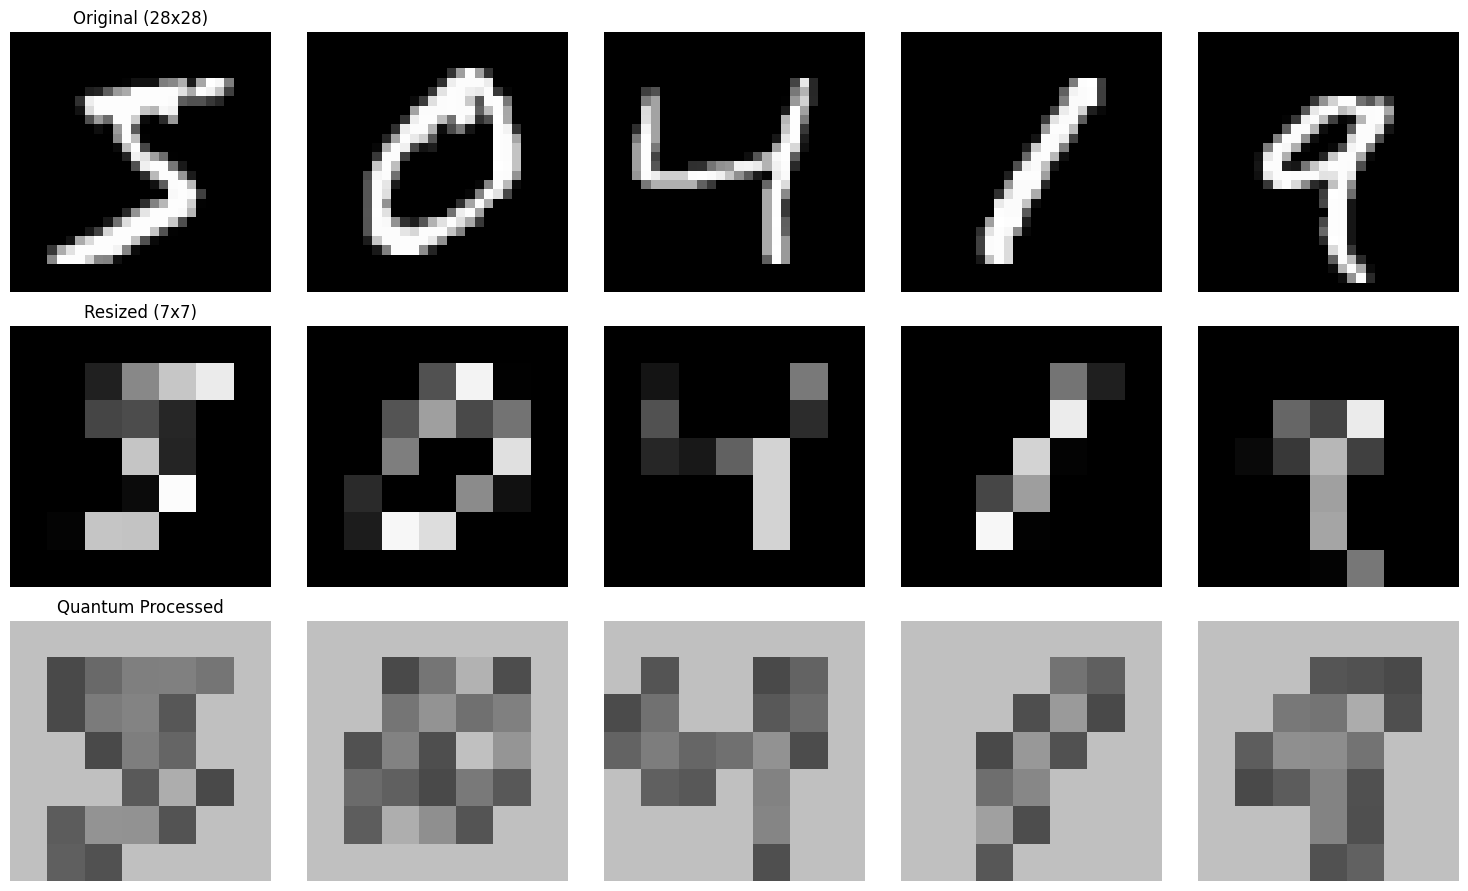


Image statistics:
Original shape: (28, 28, 1)
Resized shape: (7, 7, 1)
Quantum processed shape: (7, 7, 4)


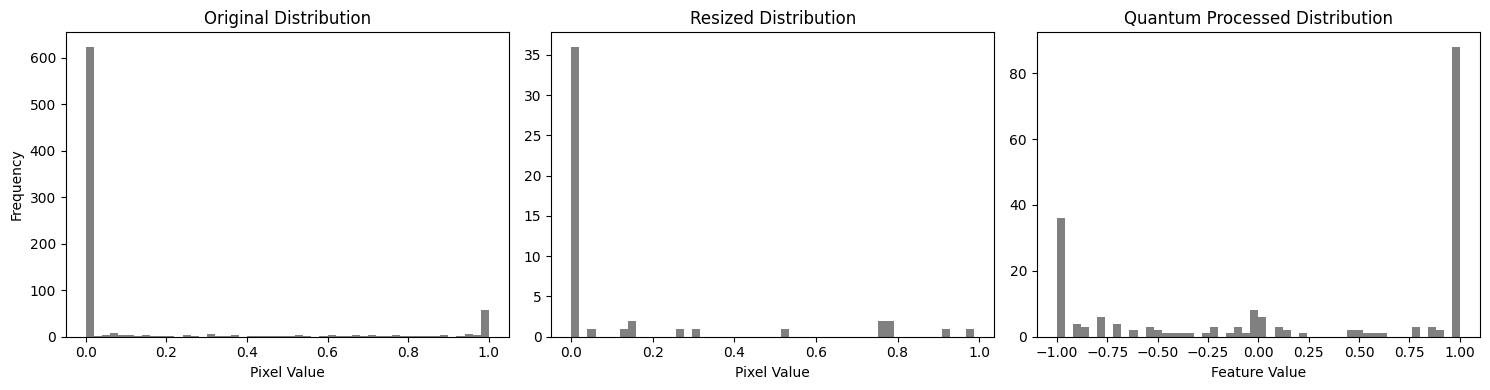


Value distribution...


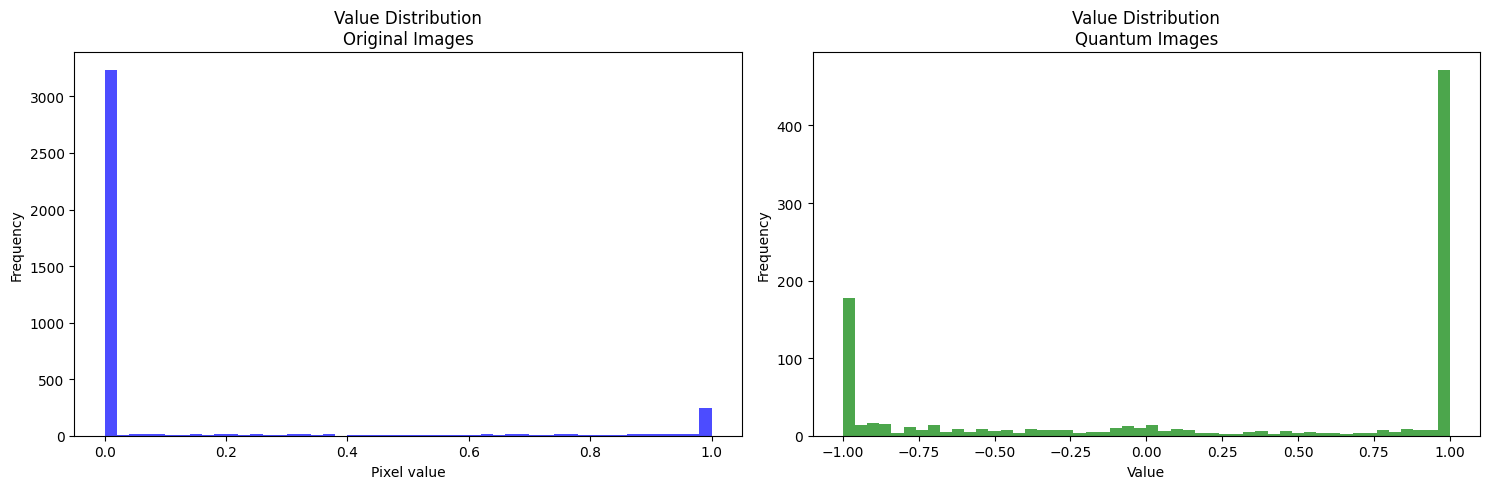


Analyzing quantum feature importance...


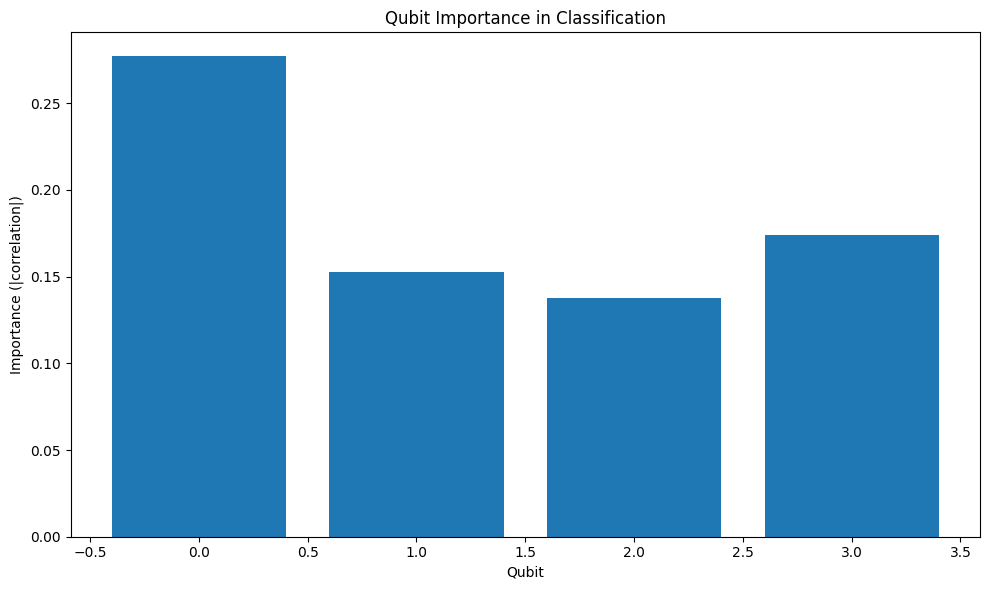

Training quantum model...
Epoch 1/40
16/16 [==============================] - 1s 20ms/step - loss: 2.2731 - accuracy: 0.1840 - val_loss: 1.8909 - val_accuracy: 0.3467
Epoch 2/40
16/16 [==============================] - 0s 5ms/step - loss: 1.5000 - accuracy: 0.5540 - val_loss: 1.4450 - val_accuracy: 0.5367
Epoch 3/40
16/16 [==============================] - 0s 5ms/step - loss: 1.1657 - accuracy: 0.6800 - val_loss: 1.2044 - val_accuracy: 0.6100
Epoch 4/40
16/16 [==============================] - 0s 6ms/step - loss: 0.9335 - accuracy: 0.7480 - val_loss: 1.0681 - val_accuracy: 0.6433
Epoch 5/40
16/16 [==============================] - 0s 5ms/step - loss: 0.7762 - accuracy: 0.7680 - val_loss: 0.9738 - val_accuracy: 0.6967
Epoch 6/40
16/16 [==============================] - 0s 5ms/step - loss: 0.6541 - accuracy: 0.8100 - val_loss: 0.9035 - val_accuracy: 0.7267
Epoch 7/40
16/16 [==============================] - 0s 5ms/step - loss: 0.6173 - accuracy: 0.8180 - val_loss: 0.8333 - val_accuracy: 

In [ ]:
def configure_tensorflow():
    try:
        tf.config.threading.set_intra_op_parallelism_threads(3)
        tf.config.threading.set_inter_op_parallelism_threads(2)

        tf.keras.mixed_precision.set_global_policy('float32')

    except Exception as e:
        print(f"Error during TensorFlow configuration: {e}")

configure_tensorflow()

n_epochs = 40
n_layers = 1
n_qubits = 4
n_train = 500
n_test = 300
batch_size = 16
CHUNK_SIZE = 8

SAVE_PATH = "./quanvolution/"
PREPROCESS = True
np.random.seed(42)
tf.random.set_seed(42)

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

train_images = np.array(train_images[:n_train]) / 255.0
train_labels = np.array(train_labels[:n_train])
test_images = np.array(test_images[:n_test]) / 255.0
test_labels = np.array(test_labels[:n_test])

train_images = tf.convert_to_tensor(train_images[..., np.newaxis], dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images[..., np.newaxis], dtype=tf.float32)

def clear_memory():
    gc.collect()
    tf.keras.backend.clear_session()

def get_optimal_thread_count():
    try:
        physical_cores = 2
        logical_cores = 4
        available_memory = psutil.virtual_memory().available / (1024 ** 3)

        optimal_workers = min(
            3,
            int(available_memory / 2),
            logical_cores - 1
        )

        return max(2, optimal_workers)
    except Exception as e:
        print(f"Error during optimal thread calculation: {e}")
        return 2

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="tf", diff_method="parameter-shift")
def circuit(inputs):
    inputs = np.nan_to_num(inputs, nan=0.0, posinf=1.0, neginf=0.0)
    inputs = np.clip(inputs, 0, 1)

    for i in range(n_qubits):
        qml.RY(inputs[i] * np.pi, wires=i)

    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


def process_batch(images_batch):
    return [process_image(image) for image in images_batch]

def process_single_patch(patch):
    try:
        patch_np = patch.numpy() if isinstance(patch, tf.Tensor) else patch
        patch_np = patch_np.astype(np.float32)

        patch_np = (patch_np - np.min(patch_np)) / (np.max(patch_np) - np.min(patch_np) + 1e-8)

        with qml.tape.QuantumTape() as tape:
            result = circuit(patch_np)

        return np.array(result, dtype=np.float32)
    except Exception as e:
        print(f"Error in process_single_patch: {e}")
        return np.zeros(n_qubits, dtype=np.float32)

def process_patch(patch):
    return tf.py_function(
        func=process_single_patch,
        inp=[patch],
        Tout=tf.float32
    )

@tf.function
def update_output_slice(output, j, k, result):
    for i in range(n_qubits):
        output = tf.tensor_scatter_nd_update(
            output,
            [[j, k, i]],
            [result[i]]
        )
    return output

@tf.function(experimental_relax_shapes=True)
def process_image(image):
    output = tf.zeros((7, 7, n_qubits), dtype=tf.float32)

    def calculate_std(x):
        mean = tf.reduce_mean(x)
        squared_diff = tf.square(x - mean)
        variance = tf.reduce_mean(squared_diff)
        return tf.sqrt(variance + 1e-8)

    for j in range(0, 7):
        for k in range(0, 7):
            j_start = j * 4
            k_start = k * 4

            patch_region = image[j_start:j_start+4, k_start:k_start+4, 0]

            patch = tf.stack([
                tf.reduce_mean(patch_region),
                tf.reduce_max(patch_region),
                tf.reduce_min(patch_region),
                calculate_std(patch_region)
            ])

            result = process_patch(patch)
            output = tf.tensor_scatter_nd_update(
                output,
                [[j, k, i] for i in range(n_qubits)],
                result
            )

    return output

def preprocess_quantum(images):
    processed_images = []
    optimal_workers = get_optimal_thread_count()

    print(f"Using {optimal_workers} workers for preprocessing")

    batch_size = 20
    for i in tqdm(range(0, len(images), batch_size)):
        batch = images[i:i + batch_size]

        with ThreadPoolExecutor(max_workers=optimal_workers) as executor:
            futures = [executor.submit(process_image, img) for img in batch]

            for future in futures:
                try:
                    result = future.result()
                    processed_images.append(result)
                except Exception as e:
                    print(f"Error processing an image: {e}")
                    processed_images.append(tf.zeros((7, 7, n_qubits), dtype=tf.float32))

        gc.collect()

    return tf.stack(processed_images)

if PREPROCESS:
    print("Preprocessing training images...")
    q_train_images = preprocess_quantum(train_images)

    print("Preprocessing test images...")
    q_test_images = preprocess_quantum(test_images)

    train_images_resized = resize_classical_images(train_images)
    test_images_resized = resize_classical_images(test_images)

    os.makedirs(SAVE_PATH, exist_ok=True)

    np.save(SAVE_PATH + "q_train_images.npy", q_train_images.numpy())
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images.numpy())
    print("Preprocessing completed and results saved.")

    print("\nVisualizing samples...")
    visualize_preprocessing(
        train_images[:5],
        q_train_images[:5],
        train_images_resized[:5]
    )

    print("\nValue distribution...")
    plot_value_distributions(train_images[:5], q_train_images[:5])

    print("\nAnalyzing quantum feature importance...")
    analyze_quantum_feature_importance()

    clear_memory()

else:
    q_train_images = tf.convert_to_tensor(np.load(SAVE_PATH + "q_train_images.npy"))
    q_test_images = tf.convert_to_tensor(np.load(SAVE_PATH + "q_test_images.npy"))

def create_base_model(input_shape):
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

train_images_resized = resize_classical_images(train_images)
test_images_resized = resize_classical_images(test_images)

quantum_model = create_base_model(input_shape=(7, 7, n_qubits))
classical_model = create_base_model(input_shape=(7, 7, 1))


print("Training quantum model...")
q_history = quantum_model.fit(
    q_train_images, train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=32,
    epochs=n_epochs,
    verbose=1
)

print("Training classical model...")
c_history = classical_model.fit(
    train_images_resized, train_labels,
    validation_data=(test_images_resized, test_labels),
    batch_size=32,
    epochs=n_epochs,
    verbose=1
)




Comparative analysis of learning evolution...


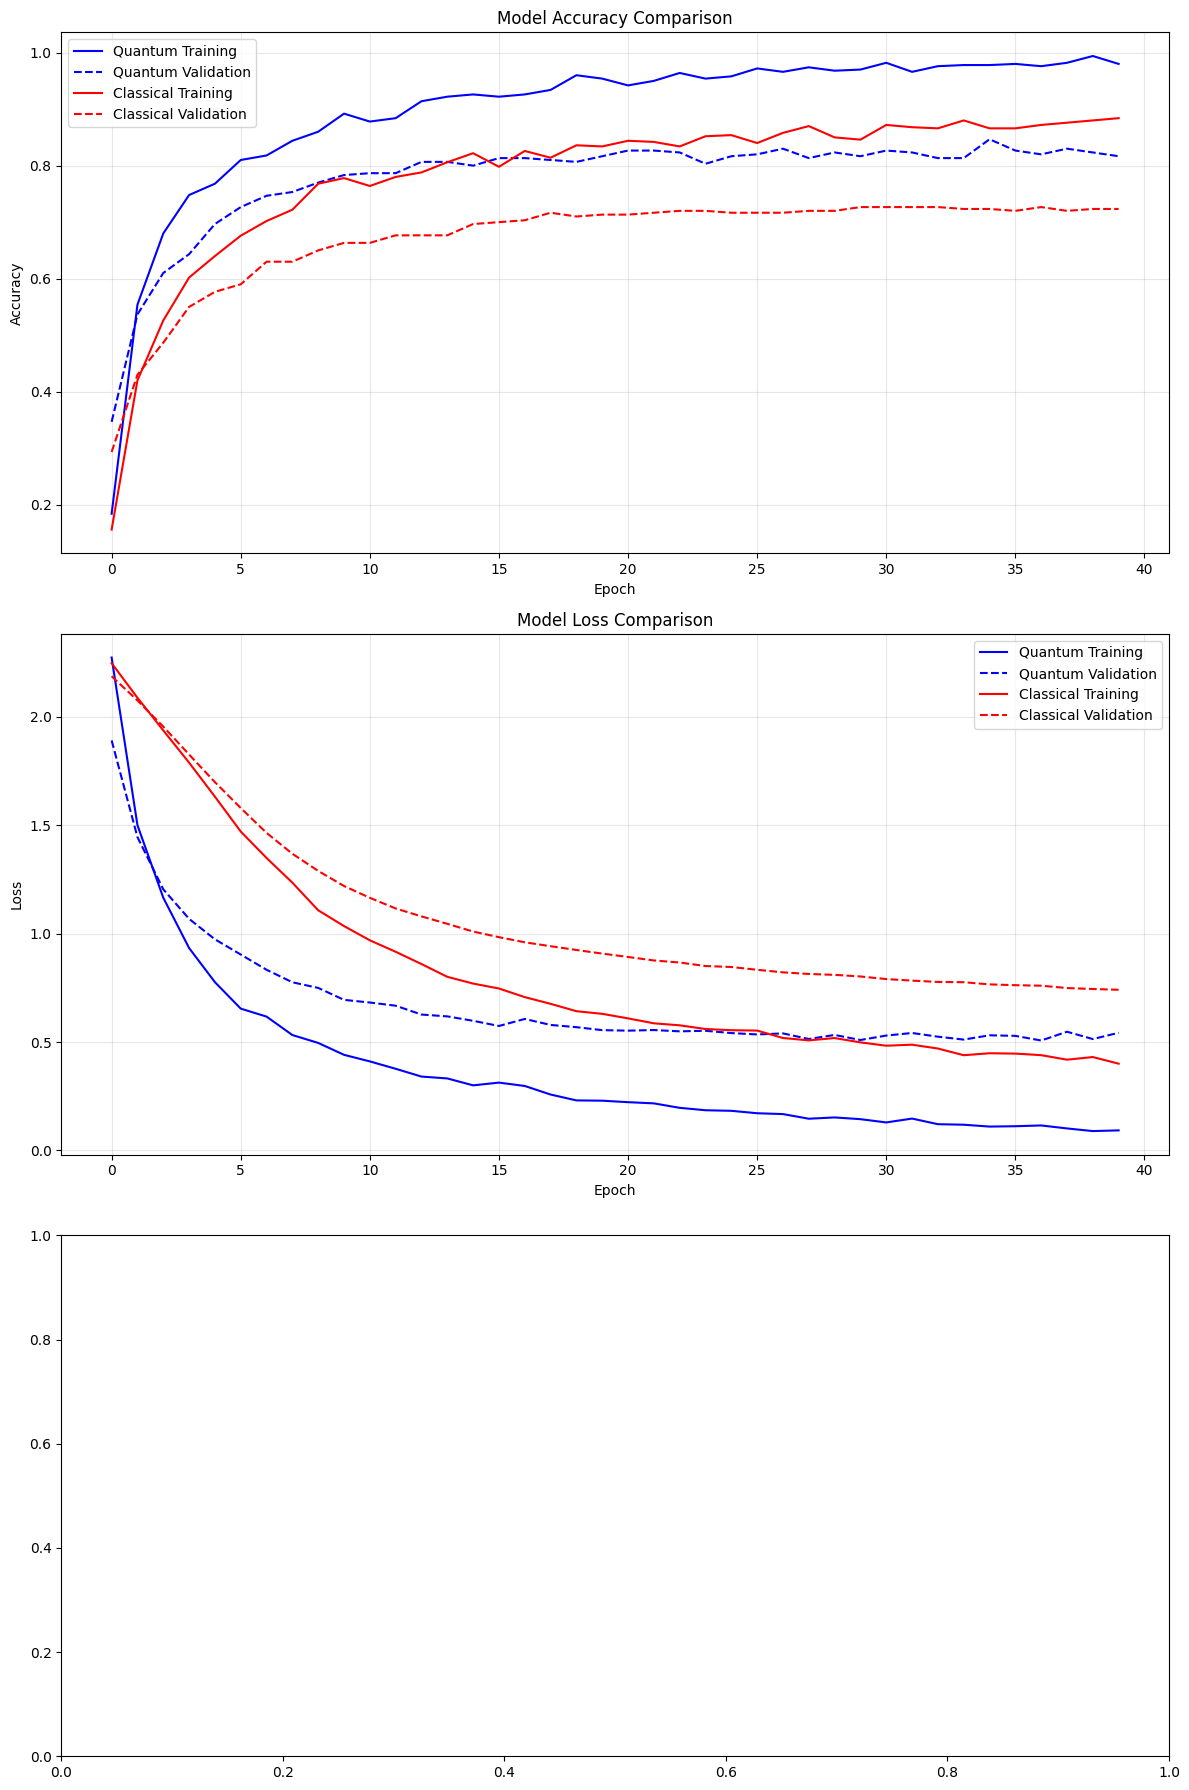


Performance Summary:
Quantum Model:
Final training accuracy: 0.9800
Final validation accuracy: 0.8167
Best validation accuracy: 0.8467

Classical Model:
Final training accuracy: 0.8840
Final validation accuracy: 0.7233
Best validation accuracy: 0.7267
10/10 [==============================] - 0s 2ms/step

Confidence Statistics:

Quantum Model:
Global accuracy: 0.8167
Mean Confidence (correct predictions): 0.8927
Mean Confidence (incorrect predictions): 0.6599

Classical Model:
Global accuracy: 0.7233
Mean Confidence (correct predictions): 0.7826
Mean Confidence (incorrect predictions): 0.5099

Performance by class:
  Class    Quantum  Classical
------------------------------
       0     1.0000     0.9583
       1     0.9512     0.9756
       2     0.8750     0.6875
       3     0.5833     0.7917
       4     0.6216     0.5946
       5     0.8276     0.4483
       6     0.7917     0.6250
       7     0.8824     0.7647
       8     0.7143     0.6190
       9     0.8529     0.7059


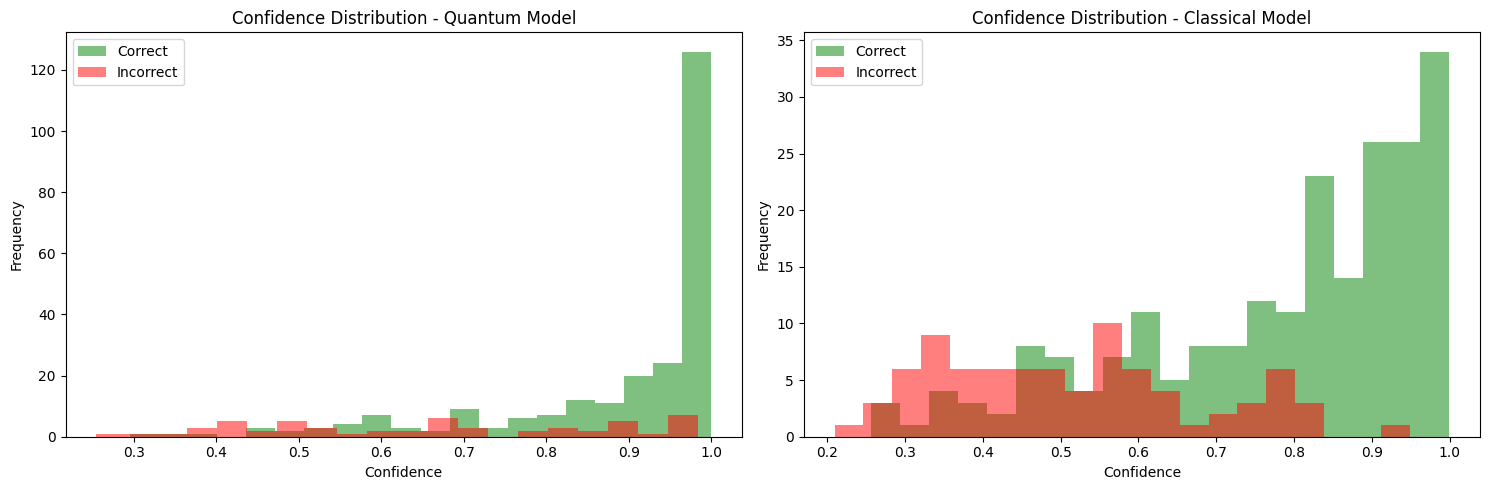

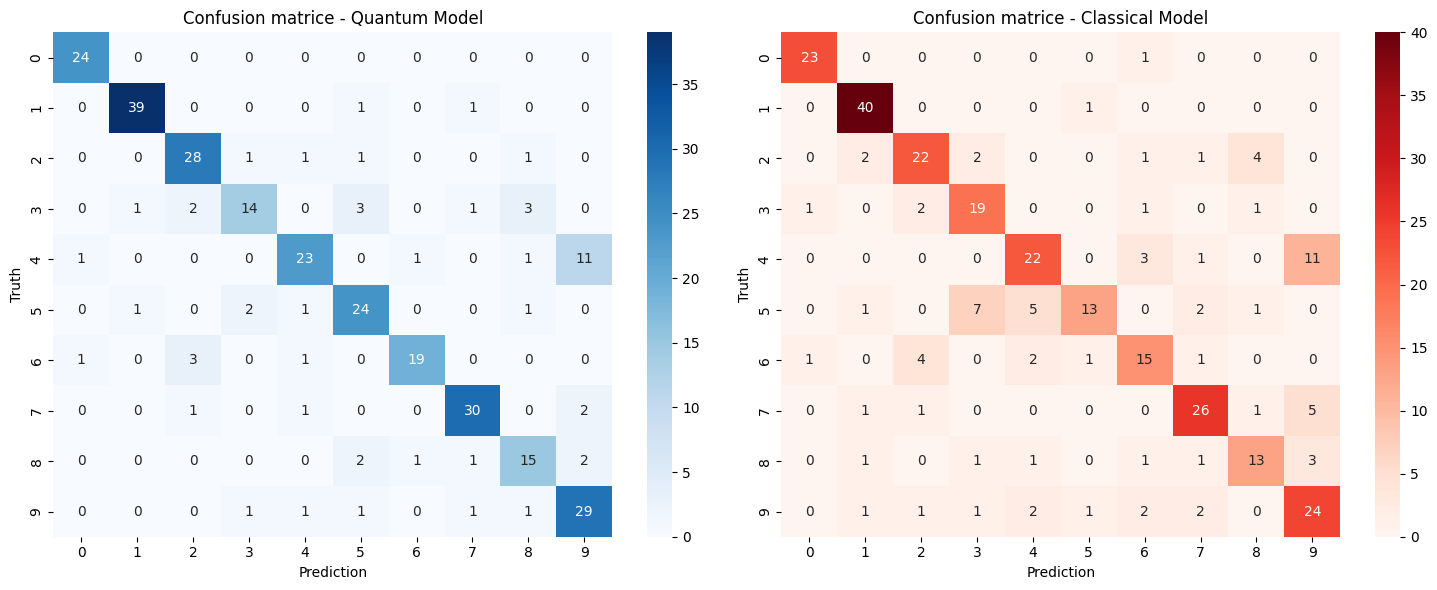

In [ ]:
print("\nComparative analysis of learning evolution...")
plot_comparative_training_evolution(
    q_history,
    c_history,
    quantum_model,
    classical_model,
    test_images_resized,
    test_images,
    test_labels
)
analyze_prediction_confidence()